In [1]:
import os, sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from adjustText import adjust_text
from utils.evaluate import get_jsdiv
from pandas.api.types import CategoricalDtype
basemap = cx.providers.CartoDB.VoyagerNoLabels

In [2]:
pth = os.path.join('..', '..', 'data', 'geodataframe_density.gpkg')
gdf = gpd.read_file(pth)
gdf_us = gdf.loc[gdf.US].copy(); gdf_us

,city,state,country,latitude,longitude,population,msa,US,cluster,cluster_ref,log10_dpc,geometry
20,long island city,new york,united states,40.74482,-73.94875,25595,New York-Northern New Jersey-Long Island NY-NJ...,True,new york city new york united states,new york city new york united states,-4.473262,POINT (-8231937.195 4974775.222)
36,whittier,california,united states,33.97918,-118.03284,87438,Los Angeles-Long Beach-Santa Ana CA MSA,True,los angeles california united states,los angeles california united states,-4.183532,POINT (-13139355.646 4026006.751)
41,williamsburg,new york,united states,40.71427,-73.95347,33000,None,True,new york city new york united states,new york city new york united states,-4.046334,POINT (-8232462.623 4970287.468)
47,calverton,maryland,united states,39.05761,-76.93581,17724,New York-Northern New Jersey-Long Island NY-NJ...,True,washington washington d c united states,washington washington d c united states,-3.980837,POINT (-8564455.193 4729927.074)
70,astoria,new york,united states,40.77205,-73.93014,150165,New York-Northern New Jersey-Long Island NY-NJ...,True,new york city new york united states,new york city new york united states,-3.801987,POINT (-8229865.539 4978777.01)
...,...,...,...,...,...,...,...,...,...,...,...,...
24022,kotzebue,alaska,united states,66.89846,-162.59809,3277,None,True,None,kenai alaska united states,2.076337,POINT (-18100336.583 10127190.134)
24023,wainwright,alaska,united states,70.63694,-160.03833,580,Fairbanks AK MSA,True,None,kenai alaska united states,2.088343,POINT (-17815385.403 11279260.931)
24024,solomon,alaska,united states,64.55961,-164.44310,12,None,True,None,kenai alaska united states,2.101738,POINT (-18305722.156 9493315.402)
24025,nome,alaska,united states,64.50111,-165.40639,3806,None,True,None,kenai alaska united states,2.129314,POINT (-18412955.109 9478171.921)


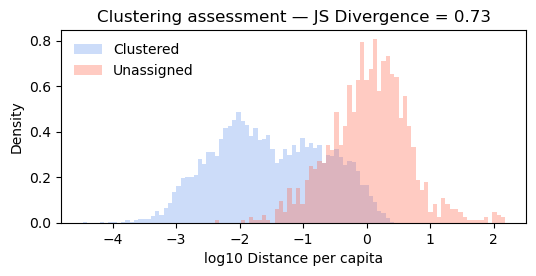

In [3]:
jsdiv, ax = get_jsdiv(gdf_us, 'cluster',
                      plot = True,
                      return_ax = True,
                      clus_label = 'Clustered',
                      other_label = 'Unassigned')
ax.set_title(f'Clustering assessment — JS Divergence = {jsdiv.round(2)}')
ax.set_xlabel('log10 Distance per capita')
ax.set_ylabel('Density')
plt.show()

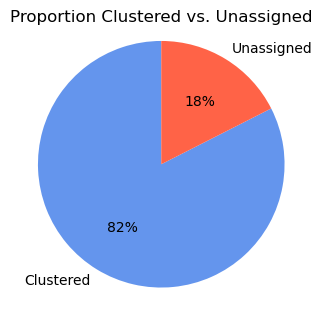

In [4]:
counts = gdf_us.cluster.notna().value_counts().rename(
    {True : 'Clustered', False : 'Unassigned'})
fig, ax = plt.subplots(1, 1, figsize = (3.5, 3.5))
counts.plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    startangle = 90,
    colors = ['cornflowerblue', 'tomato'],
    ylabel = '',
    legend = False)
ax.set_title('Proportion Clustered vs. Unassigned')
ax.axis('equal')
plt.show()

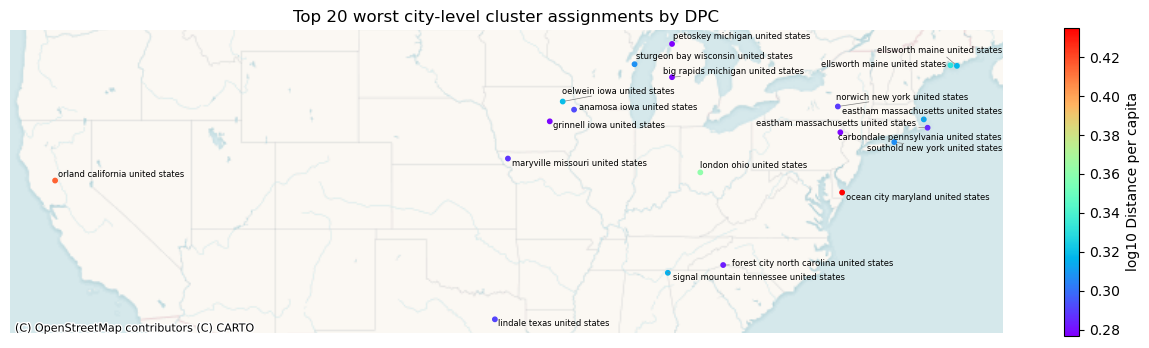

In [5]:
# worst city-level cluster assignments by DPC
top_n, ms, fs = 20, 10., 6.
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
gdf_plt = gdf_us.loc[gdf_us.cluster.notna()].copy()
gdf_plt.tail(top_n).plot(
    column = 'log10_dpc',
    cmap = 'rainbow',
    markersize = ms,
    legend = True,
    legend_kwds = {'label': 'log10 Distance per capita', 'shrink' : .25},
    ax = ax)
cx.add_basemap(ax, source = basemap)
labels = [ax.text(row.geometry.x, row.geometry.y, row.cluster, fontsize = fs)
          for _, row in gdf_plt.tail(top_n).iterrows()]
adjust_text(labels, ax = ax, arrowprops = dict(arrowstyle = '-', color = 'gray', lw = .5))
ax.set_title(f'Top {top_n} worst city-level cluster assignments by DPC')
ax.axis(False)
plt.show()

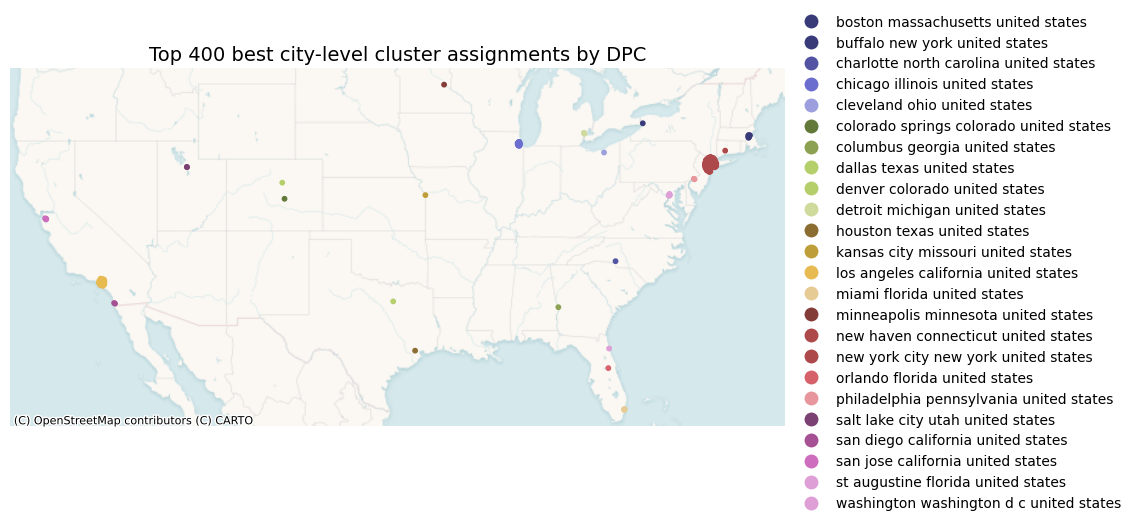

In [6]:
# best city-level cluster assignments by DPC
top_n = 400
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
gdf_plt.head(top_n).plot(
    column = 'cluster',
    cmap = 'tab20b',
    markersize = ms,
    legend = True,
    ax = ax)
cx.add_basemap(ax, source = basemap)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1.185))
leg.set_frame_on(False)
ax.set_title(f'Top {top_n} best city-level cluster assignments by DPC', size = 14)
ax.axis(False)
plt.show()

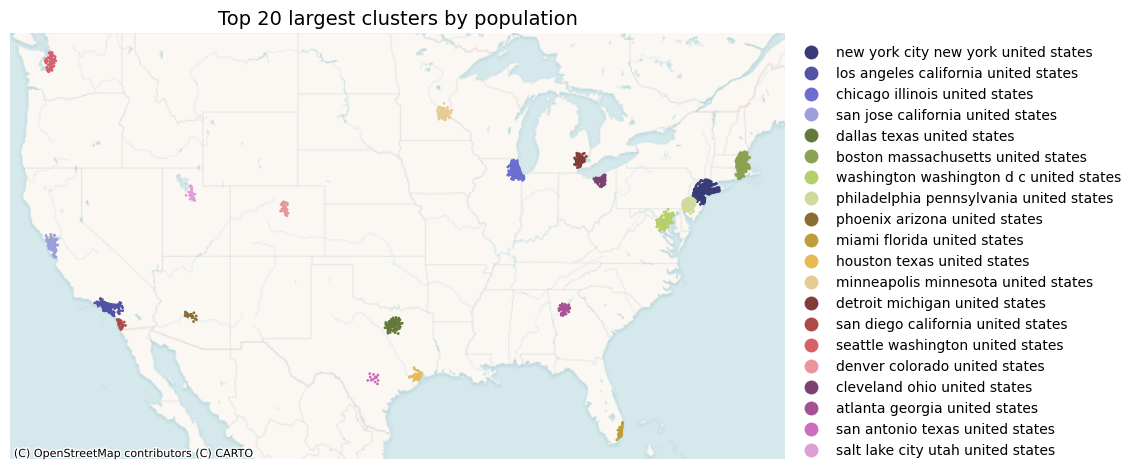

In [7]:
# largest clusters by poulation
top_n, ms = 20, 1.
largest = (gdf_us.loc[gdf_us.cluster.notna()]
           .groupby('cluster').population.sum()
           .sort_values(ascending = False)
           .head(top_n))
gdf_plt = gdf_us.loc[gdf_us.cluster.isin(largest.index)].copy()
gdf_plt['cluster_population'] = gdf_plt.cluster.map(largest)
gdf_plt.sort_values('cluster_population', ascending = False, inplace = True)
gdf_plt['cluster'] = gdf_plt.cluster.astype(
    CategoricalDtype(categories = gdf_plt.cluster.unique().tolist(), ordered = True))

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
gdf_plt.plot(
    column = 'cluster',
    cmap = 'tab20b',
    markersize = ms,
    legend = True,
    ax = ax)
cx.add_basemap(ax, source = basemap)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1))
leg.set_frame_on(False)
ax.set_title(f'Top {top_n} largest clusters by population', size = 14)
ax.axis(False)
plt.show()

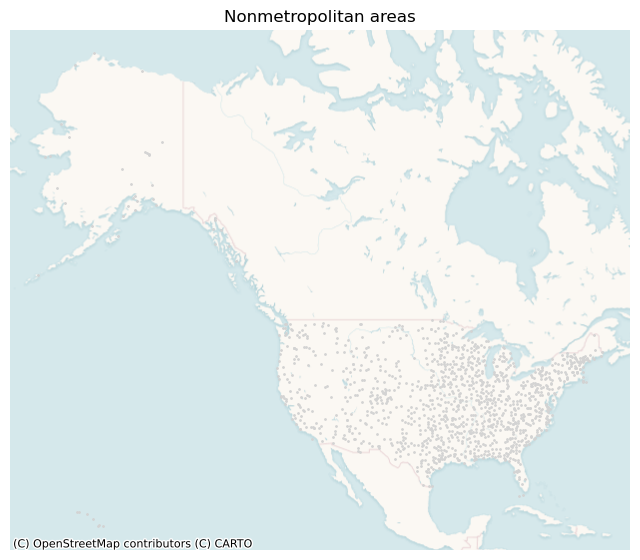

In [8]:
# unassigned nonmetropolitan areas
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
gdf_us.loc[gdf_us.cluster.isna()].plot(color = 'lightgrey',
                                       markersize = ms,
                                       ax = ax)
cx.add_basemap(ax, source = basemap, zorder = 0)
ax.set_title('Nonmetropolitan areas')
ax.axis(False)
plt.show()

In [9]:
# noisy MSA vs. clustering label comparison
top_n = 20
gdf_plt = gdf_us[['msa', 'cluster', 'population']].dropna()
top_msa = gdf_plt.groupby('msa').population.sum().nlargest(top_n).index
top_clus = gdf_plt.groupby('cluster').population.sum().nlargest(top_n).index
gdf_plt = gdf_plt.loc[gdf_plt.msa.isin(top_msa) & gdf_plt.cluster.isin(top_clus)]
flows = gdf_plt.groupby(['msa', 'cluster']).size().reset_index(name = 'value')
labels = pd.Index(pd.concat([flows.msa, flows.cluster]).unique())
label_map = {k: i for i, k in enumerate(labels)}

fig = go.Figure(go.Sankey(
    node = dict(
        label = labels.tolist(),
        pad = 5,
        thickness = 100),
    link = dict(
        source = flows.msa.map(label_map),
        target = flows.cluster.map(label_map),
        value = np.log10(flows.value))))
fig.update_layout(title = f'Label comparison for top {top_n} metropolitan areas — Noisy MSA (left) vs. iterative density-based clustering (right)')
fig.show()